<h4>Instalamos el paquete fer</h4>

In [ ]:
%pip install fer

<h4>Importando los módulos necesario</h4>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from numpy.linalg import norm
from fer import FER
import matplotlib.pyplot as plt 
import cv2
import mlflow 
from mlflow.tracking import MlflowClient

<h4>Creamos el experimento</h4>

In [2]:
mlflow.set_experiment('RandomForestC_Isaías')

2022/05/19 01:47:18 INFO mlflow.tracking.fluent: Experiment with name 'RandomForestC_Isaías' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/luisg/Downloads/spotify-recommender-systems-main/mlruns/1', experiment_id='1', lifecycle_stage='active', name='RandomForestC_Isaías', tags={}>

<h2>Recomendador de canciones</h3>

<h4>Cargar información del Usuario</h4>
Esta información fue obtenida desde la API de spotify, donde previamente se solicita permiso al usuario para obtener los datos y tratarlos con la ayuda de algunas funciones.

Usuario: Isaías

In [3]:
top_artist_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user1/top_artists.pkl?raw=true')
top_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user1/top_tracks.pkl?raw=true')
saved_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user1/saved_tracks.pkl?raw=true')
playlist_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user1/playlist_tracks.pkl?raw=true')
recommendation_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user1/recommendation_tracks.pkl?raw=true')

with open(r'C:\Users\luisg\Downloads\spotify-recommender-systems-main\local\playlists1.yml') as stream:
    playlists = yaml.safe_load(stream)


Usuario: Luis

In [ ]:
top_artist_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user2/top_artists.pkl?raw=true')
top_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user2/top_tracks.pkl?raw=true')
saved_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user2/saved_tracks.pkl?raw=true')
playlist_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user2/playlist_tracks.pkl?raw=true')
recommendation_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user2/recommendation_tracks.pkl?raw=true')

with open(r'C:\Users\luisg\Downloads\spotify-recommender-systems-main\local\playlists2.yml') as stream:
    playlists = yaml.safe_load(stream)


In [4]:
# Eliminar duplicados en el ID
playlist_tracks_df = playlist_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()
recommendation_tracks_df = recommendation_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()
# Prevenir data leakage
recommendation_tracks_df = recommendation_tracks_df[~recommendation_tracks_df['id'].isin(playlist_tracks_df['id'].tolist())]

Para evitar tener que etiquetar todas las canciones que tenemos del 1 al 10. Lo hacemos como un problema de clasificación.
<br/>
Tendremos un 1 para las canciones que estén dentro de nuestras más escuchadas, que sean de nuestros artistas más escuchados o estén guardadas. Y un 0 de otro modo.

In [5]:
saved_tracks_list = list(saved_tracks_df['id'])
top_tracks_list = list(top_tracks_df['id'])
top_artist_list = list(top_artist_df['id'])

playlist_tracks_df['ratings'] = playlist_tracks_df['id'].apply(lambda x: 1 if x in top_tracks_list else 0)
playlist_tracks_df['ratings'] = playlist_tracks_df.apply(lambda x: 1 if x['artist_id'] in top_artist_list else x.ratings, axis=1)
playlist_tracks_df['ratings'] = playlist_tracks_df.apply(lambda x: 1 if x['id'] in saved_tracks_list else x.ratings, axis=1)

<h4>Crear los datos de entrenamiento y de prueba<h4>

In [6]:
# Training data
X = playlist_tracks_df[['popularity', 'explicit', 'duration_ms', 'danceability', 'energy',
                        'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                        'liveness', 'valence', 'tempo', 'time_signature', 'genres']]  # order here is important for xgboost later
y = playlist_tracks_df['ratings']

# Drop NA
X = X.dropna()
recommendation_tracks_df = recommendation_tracks_df.dropna()

# Crear columnas de géneros (one-hot encoding)
X = X.drop('genres', 1).join(X['genres'].str.join('|').str.get_dummies())
X_recommend = recommendation_tracks_df.copy()
X_recommend = X_recommend.drop('genres', 1).join(X_recommend['genres'].str.join('|').str.get_dummies())

# Asegurarse de que las características sean consistentes en el entrenamiento, la prueba y la evaluación
X = X[X.columns.intersection(X_recommend.columns)]
X_recommend = X_recommend[X_recommend.columns.intersection(X.columns)]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\luisg\AppData\Local\Temp\ipykernel_14876\725810985.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X.drop('genres', 1).join(X['genres'].str.join('|').str.get_dummies())
C:\Users\luisg\AppData\Local\Temp\ipykernel_14876\725810985.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_recommend = X_recommend.drop('genres', 1).join(X_recommend['genres'].str.join('|').str.get_dummies())


<h4> Guardamos parámetros y métricas </h4>

In [7]:
mlflow.sklearn.autolog()

<h4> Hacer Cross Validation para obtener el mejor número de características </h4>

2022/05/19 01:56:59 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2022/05/19 01:56:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '556e4b80ed7448eda5d187c2ac218b5e', which will track hyperparameters, performance metrics, mod

Fitting estimator with 176 features.


2022/05/19 01:57:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\luisg\.conda\envs\Rdp\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."
2022/05/19 01:57:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ea1f4b32877044528b678378729090fb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting estimator with 175 features.


2022/05/19 01:57:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '65ad262e46d7466ea3cf5c4cfca1fcd7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting estimator with 174 features.


2022/05/19 01:57:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '04838da5f5604ee2abc81db8fe06caba', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting estimator with 173 features.


2022/05/19 01:57:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '08dae287f32a4b3cac89c52ff5328c6f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting estimator with 172 features.


2022/05/19 01:58:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '82a92a6a74794aa3a946345bb3930894', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting estimator with 171 features.


2022/05/19 01:58:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '389ebdb074f94852a4999d2834347d64', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting estimator with 170 features.


2022/05/19 01:58:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '42c6d8f7dd4c41b29a806d3f341d6ceb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting estimator with 169 features.


2022/05/19 01:58:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ec80cfaf344c465f9a6c0e2a2f5188a0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting estimator with 168 features.


2022/05/19 01:58:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '980a2f6eaf964674b78bdeafbf79e010', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting estimator with 167 features.


2022/05/19 01:59:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bdd157e7c6cb46b7b5859223a0ecbd38', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting estimator with 166 features.


2022/05/19 01:59:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '62b36d35983a4ccb87263d6b6a0eeaba', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/05/19 01:59:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0678d322cf5a4450807a7215cffabe87', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Optimal number of features: 165


c:\Users\luisg\.conda\envs\Rdp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


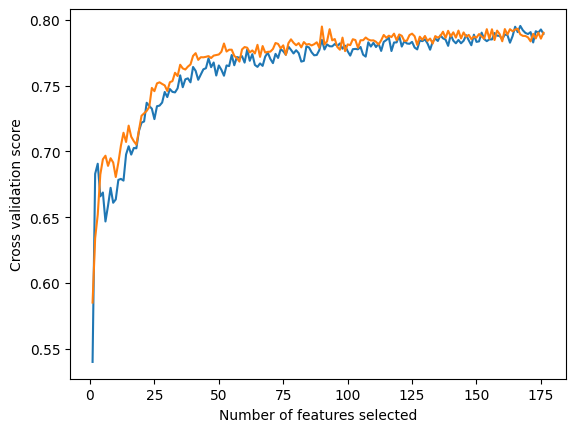

In [8]:
# Cross-validation for number of features 
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfecv = RFECV(estimator=rf, step=1, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfecv.fit(X_train, y_train)

print(f'Optimal number of features: {rfecv.n_features_}')
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

In [26]:
# Obtener las características más importantes
# Can use this with previous rfecv to reduce the number of features to speed up model training if needed 
rfc = RandomForestClassifier(n_estimators = 1000, max_depth=4, random_state=42, max_features=165)
rfc.fit(X_train, y_train)

important_features_dict = {}
for idx, val in enumerate(rfc.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)
for i in range(len(important_features_list[:80])):
    print(f"{i+1}. {X_train.columns[important_features_list[i]]} {important_features_dict[important_features_list[i]]}")

2022/05/19 02:46:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '883aea951ae04469a9ceba2e92af4d06', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/05/19 02:47:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\luisg\.conda\envs\Rdp\lib\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing V

1. acousticness 0.15626641450107187
2. loudness 0.13540697485853506
3. duration_ms 0.10173925769221777
4. corrido 0.0855789271589207
5. instrumentalness 0.05824513308734445
6. popularity 0.047459071305406476
7. trap latino 0.03300926781757176
8. valence 0.032882624538151606
9. tempo 0.03114442735071526
10. danceability 0.02613813055956483
11. liveness 0.02520888247318544
12. dfw rap 0.023090419107175634
13. energy 0.021945121806582504
14. speechiness 0.02000092066448751
15. acoustic pop 0.0179492737505083
16. nueva musica mexicana 0.017629246080695337
17. pop rap 0.014515114684431719
18. ranchera 0.012890420375425966
19. musica mexicana 0.012719946340123052
20. key 0.011385887177184197
21. norteno 0.010854679831498166
22. neo mellow 0.01019169615068627
23. time_signature 0.008624472260892538
24. pop 0.007644561351813351
25. slap house 0.007601051188220886
26. reggaeton 0.005679587109512723
27. dance pop 0.005055434634070262
28. latin 0.005014352685109052
29. trap 0.004739626076668068
3

<h3>Distintos modelos</h3>
Aquí utilizaremos el modelo. Lo entrenaremos con el modelo deseado

<h4>Aplicando el modelo de Bósques Aleatorios</h4>

In [11]:
model = RandomForestClassifier(n_estimators = 1000, random_state=42)
rfc_gcv_parameters = {'min_samples_leaf': [1, 3, 5, 8],
                       'max_depth': [3, 4, 5, 8, 12, 16, 20], 
                     }
rfe_gcv = GridSearchCV(model, rfc_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfe_gcv.fit(X_train, y_train)
print(rfe_gcv.best_estimator_, rfe_gcv.best_params_, rfe_gcv.best_score_)

print(classification_report(y_test, rfe_gcv.predict(X_test)))


2022/05/19 02:17:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd8088087dda84cb895027e12f15ed9b6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 2 folds for each of 28 candidates, totalling 56 fits


2022/05/19 02:17:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\luisg\.conda\envs\Rdp\lib\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2022/05/19 02:18:07 INFO mlflow.sklearn.utils: Logging the 5 best runs, 23 runs will be omitted.


RandomForestClassifier(max_depth=12, n_estimators=1000, random_state=42) {'max_depth': 12, 'min_samples_leaf': 1} 0.7910101946246524
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        47
           1       0.78      0.74      0.76        34

    accuracy                           0.80        81
   macro avg       0.80      0.79      0.80        81
weighted avg       0.80      0.80      0.80        81



Lo entrenamos con los mejores parámetros encontrados

In [22]:
model = RandomForestClassifier(max_depth=12, n_estimators=1500, random_state=42, min_samples_leaf=1, max_features=165)
model.fit(X_train, y_train)

2022/05/19 02:32:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c9bdf0c4b26a4e24ab404b3d0a235dd3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/05/19 02:32:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\luisg\.conda\envs\Rdp\lib\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing V

RandomForestClassifier(max_depth=12, max_features=165, n_estimators=1500,
                       random_state=42)

<h4>Aplicando el modelo XGBoost</h4>

In [ ]:
# XGBoost Classifier
model = XGBClassifier(n_estimators = 1000, random_state=42, use_label_encoder=False)
xgb_gcv_parameters = {'eta': [0.2, 0.3, 0.4, 0.5],
                      'min_child_weight': [0.3, 0.5, 0.8, 1],
                      'max_depth': [3, 4, 5, 8, 12, 16, 20], 
                     }
xgb_gcv = GridSearchCV(model, xgb_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
xgb_gcv.fit(X_train, y_train)  # use numpy values as xgboost requires fixed ordering
print(xgb_gcv.best_estimator_, xgb_gcv.best_score_)

print(classification_report(y_test, xgb_gcv.predict(X_test)))

Lo entrenamos con los mejores parámetros encontrados

In [ ]:
model = XGBClassifier(n_estimators = 1000, random_state=42, use_label_encoder=False)
model.fit(X_train, y_train)

<h4>Aplicando el modelo KNN</h4>


In [ ]:
# KNN Classifier
model = KNeighborsClassifier(n_jobs=-1)
knn_gcv_params = {'n_neighbors': range(1, 10)}

knn_gcv = GridSearchCV(model, knn_gcv_params, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
knn_gcv.fit(X_train, y_train)
print(knn_gcv.best_params_, knn_gcv.best_score_)

print(classification_report(y_test, knn_gcv.predict(X_test)))

Lo entrenamos con los mejores parámetros encontrados

In [ ]:
model = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
model.fit(X_train, y_train)

<h3> Llegó el momento de predecir</h3> 
Aquí se utilizará el modelo elegido y entrenado previamente.

In [13]:
recommendation_tracks_df['ratings'] = model.predict(X_recommend)
recommendation_tracks_df['prob_ratings'] = model.predict_proba(X_recommend)[:,1]  # slice for probability of 1
recommendation_tracks_df[recommendation_tracks_df['ratings'] == 1].head()

#tracks where prob_ratings >= 0.7 which is a good number
tracks_to_add = recommendation_tracks_df[recommendation_tracks_df['prob_ratings'] >= 0.8]

<h2>Recomendador de canciones dependiendo la emoción</h2>

Ahora que tenemos una serie de canciones las cuáles tienen una probabilidad alta de que nos gusten, elegiremos aquellas que vayan de acuerdo al mood actual.

Extraemos la emoción de la persona de la imagen. Para esto utilizamos FER.

Imagen: Isaías

C:\Users\luisg\AppData\Local\Temp\ipykernel_14876\3229747675.py:2: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  test_image_one = plt.imread(image_path,format="jpg")


1/1 [==============================] - 0s 25ms/step
[{'box': [378, 549, 138, 172], 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}]


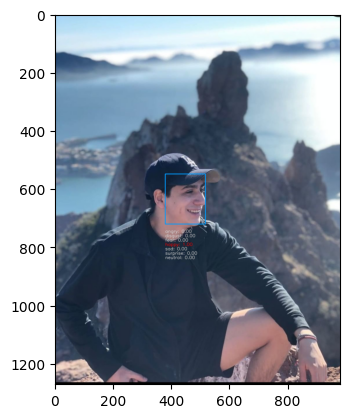

In [14]:
image_path = "https://github.com/joseisaias06/FER_Spotify_Recommender/raw/main/images/face_image12.jpg"
test_image_one = plt.imread(image_path,format="jpg")
emo_detector = FER(mtcnn=True)
captured_emotions = emo_detector.detect_emotions(test_image_one)


# Print all captured emotions with the image

bounding_box = captured_emotions[0]["box"]
emotions = captured_emotions[0]["emotions"]
cv2.rectangle(test_image_one,(
  bounding_box[0], bounding_box[1]),(
  bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0, 155, 255), 2,)

emotion_name, score = emo_detector.top_emotion(test_image_one)
mood = emotion_name
for index, (emotion_name, score) in enumerate(emotions.items()):
  color = (211, 211,211) if score < 0.07 else (255, 0, 0)
  emotion_score = "{}: {}".format(emotion_name, "{:.2f}".format(score))

  cv2.putText(test_image_one,emotion_score,
              (bounding_box[0], bounding_box[1] + bounding_box[3] + 30 + index * 15),
              cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1,cv2.LINE_AA,)


plt.imshow(test_image_one)
print(captured_emotions)
plt.show()


Imagen: Luis

C:\Users\luisg\AppData\Local\Temp\ipykernel_14876\3229747675.py:2: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  test_image_one = plt.imread(image_path,format="jpg")


1/1 [==============================] - 0s 25ms/step
[{'box': [378, 549, 138, 172], 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}]


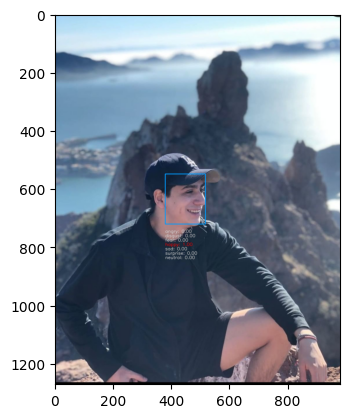

In [ ]:
image_path = "https://github.com/joseisaias06/FER_Spotify_Recommender/raw/main/images/face_image13.jpeg"
test_image_one = plt.imread(image_path,format="jpeg")
emo_detector = FER(mtcnn=True)
captured_emotions = emo_detector.detect_emotions(test_image_one)


# Print all captured emotions with the image

bounding_box = captured_emotions[0]["box"]
emotions = captured_emotions[0]["emotions"]
cv2.rectangle(test_image_one,(
  bounding_box[0], bounding_box[1]),(
  bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0, 155, 255), 2,)

emotion_name, score = emo_detector.top_emotion(test_image_one)
mood = emotion_name
for index, (emotion_name, score) in enumerate(emotions.items()):
  color = (211, 211,211) if score < 0.07 else (255, 0, 0)
  emotion_score = "{}: {}".format(emotion_name, "{:.2f}".format(score))

  cv2.putText(test_image_one,emotion_score,
              (bounding_box[0], bounding_box[1] + bounding_box[3] + 30 + index * 15),
              cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1,cv2.LINE_AA,)


plt.imshow(test_image_one)
print(captured_emotions)
plt.show()


Para seleccionar el tipo de canciones para cada mood, nos basamos en las características de 'Energy' y 'Valence' de cada canción, guiados por Circumplex Model of Affect(Russell 1980).

Dependiendo del estado de ánimo, creamos un vector con determinados valores con el que prodemos calcular la distancia y obtener las canciones más adecuadas.

In [15]:
top_tracks_df['mood_vector'] = top_tracks_df[['valence','energy']].values.tolist()
if mood == 'happy':
    track_moodvec = np.array([1, 1])
elif mood == 'sad':
    track_moodvec = np.array([0, 0.0])
elif mood == 'angry':
    track_moodvec = np.array([0.35, 0.75])
elif mood == 'disgust':
    track_moodvec = np.array([0.42, 0.9])
elif mood == 'fear':
    track_moodvec = np.array([0.3, 0.5])
elif mood == 'surprise':
    track_moodvec = np.array([0.55, 0.8])
elif mood == 'neutral':
    track_moodvec = np.array([0.6, 0.45])
    
#Calculamos las distancias para cada canción    
top_tracks_df['distances'] = top_tracks_df['mood_vector'].apply(lambda x: norm(track_moodvec-np.array(x)))
emotion_track = top_tracks_df[top_tracks_df['distances'] == top_tracks_df['distances'].min()]

Finalmente, de todas las recomendaciones que obtuvimos anteriormente, elegimos aquellas que más se asemejen al mood, y podemos tomar en cuenta también la popularidad para organizar.

In [16]:
# Crawl valence and arousal of given track
track_moodvec = np.array([emotion_track.valence, emotion_track.energy])

# Compute distances to all reference tracks
tracks_to_add['mood_vector'] = tracks_to_add[['valence','energy']].values.tolist()
tracks_to_add["distances"] = tracks_to_add["mood_vector"].apply(lambda x: norm(track_moodvec-np.array(x)))

# Sort distances from lowest to highest
final_tracks = tracks_to_add.sort_values(by = ["distances"], ascending = [True])

#final_tracks['popularity'] = final_tracks['popularity'] / 100 
print(final_tracks.sort_values(by = "popularity", ascending = False)[['name', 'artist_name']])

#print(final_tracks[['name', 'artist_name']])

                                                   name           artist_name
2039                                       X ÚLTIMA VEZ          Daddy Yankee
1898  Lo Siento BB:/ (with Bad Bunny & Julieta Venegas)                 Tainy
1999                                             Sobrio                Maluma
2097                                           Callaita             Bad Bunny
2012                                         La Difícil             Bad Bunny
...                                                 ...                   ...
1963                                            Sistema         Zion & Lennox
340                                      La Nueva Etapa  Los Minis de Caborca
580                           De la Noria para el Mundo        Giovanny Ayala
538                                       FUI RECLUTADO       Abraham Vazquez
529                                          Kikil Caro         Crecer German

[275 rows x 2 columns]


C:\Users\luisg\AppData\Local\Temp\ipykernel_14876\1772204668.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_to_add['mood_vector'] = tracks_to_add[['valence','energy']].values.tolist()
C:\Users\luisg\AppData\Local\Temp\ipykernel_14876\1772204668.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_to_add["distances"] = tracks_to_add["mood_vector"].apply(lambda x: norm(track_moodvec-np.array(x)))
